In [1]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop

In [2]:
def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [3]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#DataFlair - Emotions to observe
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [4]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("C:\\Speech Emotion\\RAVESS\\Actor_*\\*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(int(file_name[7:8]) - 1)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [6]:
x_train,x_test,y_train,y_test=load_data(test_size=0.2)

In [7]:
x_traincnn = np.expand_dims(x_train, axis=2)
x_testcnn = np.expand_dims(x_test, axis=2)

In [8]:
model1=Sequential()

In [9]:
model1.add(Conv1D(16, 7,padding='same',strides=2,
                 input_shape=(180,1)))
model1.add(Activation('relu'))
model1.add(Conv1D(32, 5,padding='same',strides=2 ,))
model1.add(Activation('relu'))
model1.add(Conv1D(64, 3,padding='same',strides=2 ,))
model1.add(Activation('relu'))
model1.add(Conv1D(128, 3,padding='same',strides=2 ,))
model1.add(Activation('relu'))
model1.add(Conv1D(128, 3,padding='same',strides=2 ,))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(512))
model1.add(Dense(8))
model1.add(Activation('softmax'))
opt1 = RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)

C:\Users\ajithvarma\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 90, 16)            128       
_________________________________________________________________
activation (Activation)      (None, 90, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 45, 32)            2592      
_________________________________________________________________
activation_1 (Activation)    (None, 45, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 23, 64)            6208      
_________________________________________________________________
activation_2 (Activation)    (None, 23, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 12, 128)           2

In [11]:
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt1,
              metrics=['accuracy'])

In [12]:
from keras import callbacks
x_traincnn = np.asarray(x_traincnn)
y_train = np.asarray(y_train)
x_testcnn = np.asarray(x_testcnn)
y_test = np.asarray(y_test)

cnnhistory=model1.fit(x_traincnn, y_train, batch_size=16, epochs=550, validation_data=(x_testcnn, y_test))

Epoch 1/550
39/39 [==============================] - 2s 28ms/step - loss: 1.6144 - accuracy: 0.2492 - val_loss: 1.3807 - val_accuracy: 0.3571
Epoch 2/550
39/39 [==============================] - 1s 17ms/step - loss: 1.4184 - accuracy: 0.2932 - val_loss: 1.3169 - val_accuracy: 0.4610
Epoch 3/550
39/39 [==============================] - 1s 16ms/step - loss: 1.3709 - accuracy: 0.3176 - val_loss: 1.2923 - val_accuracy: 0.4286
Epoch 4/550
39/39 [==============================] - 1s 17ms/step - loss: 1.3278 - accuracy: 0.3388 - val_loss: 1.2971 - val_accuracy: 0.3961
Epoch 5/550
39/39 [==============================] - 1s 17ms/step - loss: 1.2903 - accuracy: 0.3746 - val_loss: 1.2235 - val_accuracy: 0.4351
Epoch 6/550
39/39 [==============================] - 1s 15ms/step - loss: 1.2471 - accuracy: 0.4055 - val_loss: 1.2317 - val_accuracy: 0.4481
Epoch 7/550
39/39 [==============================] - 1s 17ms/step - loss: 1.2126 - accuracy: 0.4381 - val_loss: 1.2066 - val_accuracy: 0.4740
Epoch 

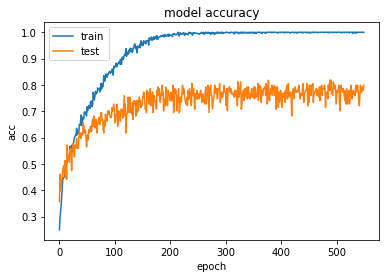

In [13]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
predictions = model1.predict_classes(x_testcnn)
new_Ytest = y_test.astype(int)
report = classification_report(new_Ytest, predictions)
print(report)

C:\Users\ajithvarma\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           1       0.87      0.89      0.88        44
           2       0.71      0.69      0.70        36
           5       0.82      0.82      0.82        33
           6       0.78      0.78      0.78        41

    accuracy                           0.80       154
   macro avg       0.79      0.79      0.79       154
weighted avg       0.80      0.80      0.80       154



In [17]:
model_name = 'Emotion_Voice_Detection_DCNN.h5'
save_dir = '/Speech Emotion'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model1.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Speech Emotion\Emotion_Voice_Detection_DCNN.h5 
